In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

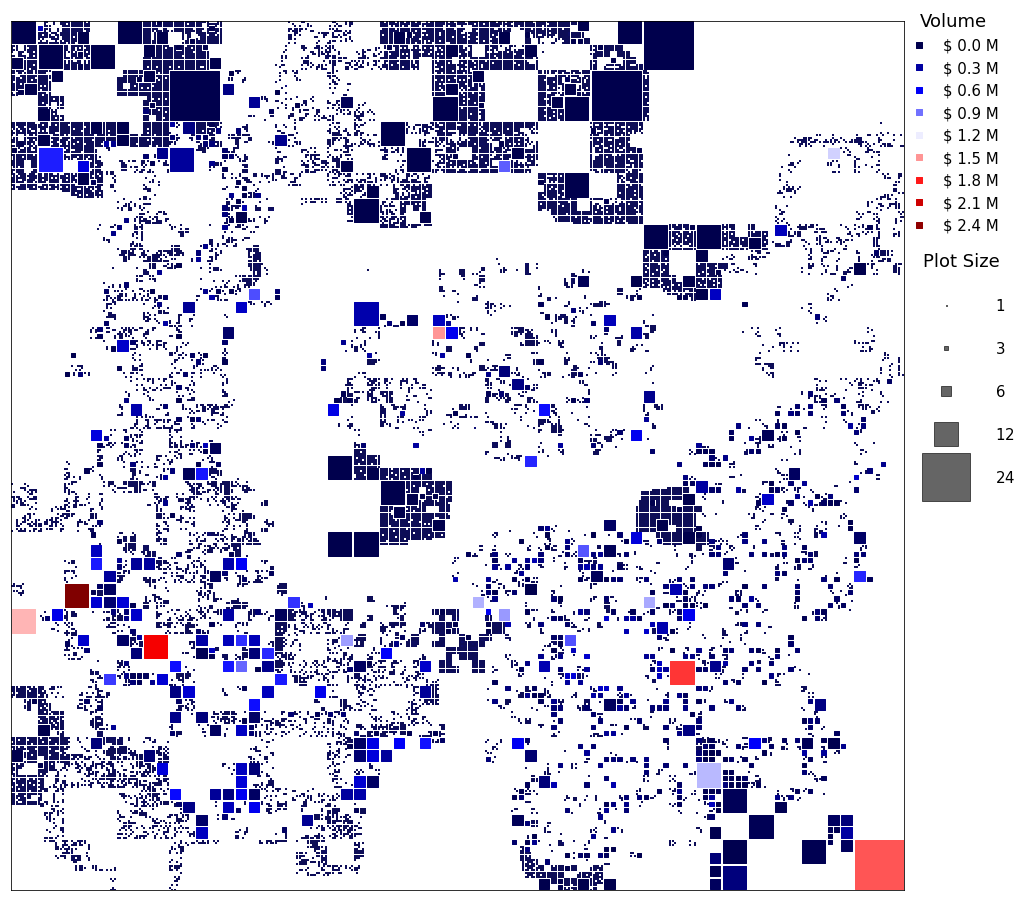

In [2]:
# Read LAND volume data
land_data = pd.read_csv('land_data.csv')

# Date fixes
land_data.set_index('Time', inplace=True)
land_data.index = [x[:19] for x in land_data.index]
land_data.index = pd.to_datetime(land_data.index, format='%Y-%m-%dT%H:%M:%S')

# Map coordinate computations
land_data['coordinate'] = land_data['X'].astype(str) + "_" + land_data['Y'].astype(str)
land_data['new_X'] = land_data['X'] + (land_data['Size'] / 2)
land_data['new_Y'] = land_data['Y'] + (land_data['Size'] / 2)
land_data['x_y_coordinates'] = land_data['new_X'].astype(str) + "_" + land_data['new_Y'].astype(str)
grouped_land_sales = land_data.groupby(['new_X', 'new_Y']).sum().reset_index()
land_sales_price_grouped = grouped_land_sales[['new_X', 'new_Y', 'LAND Price (USD)']]
land_sales_price_grouped['x_y_coordinates'] = land_sales_price_grouped['new_X'].astype(str) + "_" + land_sales_price_grouped['new_Y'].astype(str)

land_coordinate_size_mapping = dict(zip(land_data['x_y_coordinates'], land_data['Size']))
land_sales_price_grouped['size'] = [land_coordinate_size_mapping[x_y] for x_y in 
                                    land_sales_price_grouped['x_y_coordinates']]

# LAND size mulipliers to correctly size plots in heatmap
size_multipliers = {'1':1, 
                    '3':6, 
                    '6':18,
                    '12':45,
                    '24':100}

land_sales_price_grouped['size_scaled'] = [x * size_multipliers[str(x)] for x in 
                                           land_sales_price_grouped['size']]
land_sales_price_grouped['volume_millions'] = land_sales_price_grouped['LAND Price (USD)']*1e-6


# Heatmap visual
fig, ax = plt.subplots(figsize=(16, 16))
scatter = ax.scatter(x=land_sales_price_grouped['new_X'], 
                     y=land_sales_price_grouped['new_Y'], 
                     s=land_sales_price_grouped['size_scaled'], 
                     marker='s', 
                     c=land_sales_price_grouped['volume_millions'],
                     cmap='seismic')

kw = dict(fmt="$ {x:.1f} M")
legend1 = ax.legend(*scatter.legend_elements(**kw),
                    loc="lower left", title="Volume", bbox_to_anchor=(.99, .74), 
                    labelspacing=.5, handlelength=1.5, frameon=False, fontsize=15)
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=18)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
labels = ['$\\mathdefault{1}$', 
          '$\\mathdefault{3}$',
          '$\\mathdefault{6}$',
          '$\\mathdefault{12}$',
          '$\\mathdefault{24}$']
legend2 = ax.legend(handles, labels, loc="lower left", title="Plot Size", fontsize=15, bbox_to_anchor=(.99, .45), 
                    labelspacing=1.8, handlelength=5, frameon=False)
plt.setp(legend2.get_title(),fontsize=18)
ax.set_ylim([0, 407])
ax.set_xlim([0, 407])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig('land_map.png', dpi=300)